## THE PROJECT: Start with an input text and provide a schema that summarises the process described in the text

## VISUALIZATION PART (STEP 2)

How to take an action list and turn it into a complete visualisation. To achieve this, we first had to define the type of object that the NLP part would provide. We started with a dictionary where the keys represent the actions and the values represent all the actions that preceded each key action. An example is provided below:

In [68]:
exemple = {
    'A': [],
    'B': ['A'],
    'C': ['A'],
    'D': ['B', 'C', 'A'],
    'E': ['B','A'],
    'F': ['D','A','C','B'],
    'G': ['B','A','C','E', 'F']
}

The second challenge is to start from this input and succeed in defining the tasks that immediately precede each of the tasks. This is what we call the immediate antecedent. 
To do this, we used the PERT (Program Evaluation and Review Technique) method of scheduling tasks in graph theory. It is particularly effective when there are multiple dependencies between tasks.

To arrive at a more or less correct representation, this method requires the prior determination of the rank of the tasks, which facilitates the determination of the immediate antecedents.
The rank of a task corresponds to its position in the logical sequence of tasks. More precisely, the rank of a task is determined by the highest value among the ranks of all the tasks that directly precede it.
The starting rank is generally 0, since the first task does not precede any other task.

**Principle**

We look for tasks that have no antecedents, and assign them rank 0. We then remove these tasks from the list of antecedents of the other tasks. Once this is done, the tasks that have no antecedents are assigned rank 1, and so on.

This is what the function "niveau" below does:

In [ ]:
def niveau(previou): #Returns the rank of each task # Small warning, the function modifies the initial dict, so take care to send it only one copy
    
    import copy
    
    previous=copy.deepcopy(previou)
    
    # 
    def retrait (list_a, list_b) : 
        for i in list_b:
            while i in list_a:
                list_a.remove(i)
        return list_a

    def condition(dictionnaire): 
        a=False
        for j in dictionnaire:
            if len(dictionnaire[j])!=0:
                a=True
        return a        

    #Dictionary to store ranks
    rang={}
    for j in previous:
        rang[j]=0

    #Loop for browsing items
    i=1
    noeud_modifie=[]
    while(condition(previous)):
        
        sommet=[]
        
        for j in previous: #Find nodes that have no antecedents and assign them a rank
            if (len(previous[j])==0) & (not(j in noeud_modifie)) : 
                rang[j]+=i
                sommet.append(j)

        for j in previous: #Removing nodes without antecedents from the antecedents list
            previous[j]=retrait(previous[j], sommet)
        
        noeud_modifie.extend(sommet)
        i+=1

    ## A final process to take account of the last node not processed in the loop
    for j in rang:
        if rang[j]==0 : 
            rang[j]=i
    
    
    return(rang)

In [64]:
niveau(exemple)

{'A': 1, 'B': 2, 'C': 2, 'D': 3, 'E': 3, 'F': 4, 'G': 5}

Once the ranks are known, the immediate antecedents of each task can be extracted (see below):

In [ ]:
def ant_immediat(previous):
    
    import copy
    
    #
    def complement(list_a, list_b) : # 
        return(list(set(list_a)-set(list_b)))
    
    def ant_rang(x, n) : #List of all nodes of a given rank
        rang=niveau(x)
        antec=[]
        for e in rang:
            if rang[e]==n:
                antec.append(e)
        return antec
    
    #Implementation
    rang=niveau(previous)
    
    noeud_a_modifie=[]
    for j in rang:
        if rang[j]!=1:
            noeud_a_modifie.append(j)
    
    prev=copy.deepcopy(previous)
    
    for i in noeud_a_modifie:
        antec=ant_rang(previous,rang[i]-1)
        prev[i]=list(set(prev[i])-set(complement(prev[i],antec)))
        
    for i in  noeud_a_modifie:
        for j in range(rang[i]-1,1,-1):
            antec=list(set(ant_rang(previous,j))&set(previous[i]))
            antec2=copy.deepcopy(antec)
            for e in antec:
                v=False
                for u in prev[i]:
                    if e in previous[u] : v=True
                if v : antec2.remove(e)
            prev[i].extend(antec2)  
    
    for i in prev : 
        prev[i]=list(set(prev[i]))
      
    return prev

In [65]:
ant_immediat(exemple)

{'A': [],
 'B': ['A'],
 'C': ['A'],
 'D': ['C', 'B'],
 'E': ['B'],
 'F': ['D'],
 'G': ['F', 'E']}

In [ ]:
From the antecedents we can then construct the graph :

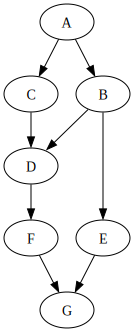

In [69]:
import copy
import graphviz  
diag=graphviz.Digraph()

immediat=ant_immediat(exemple)

    
for i in immediat :
    diag.node(i)  
    
sens=[]

for i in immediat :
    for j in immediat[i]:
        diag.edge(j, i)
        
#Display
diag
        

## NLP PART (STEP 1)

Once the visualisation part is in place, we now want to start with a text and provide the input required for visualisation: a list of actions and their antecedents.
We proceed by syntactic analysis. We assume that an action is composed mainly of a verb. To support the description of the action, we look at the complements of the verb to see if they can be added to specify the action.  The different categories of complements are treated differently: proper and common nouns are simply added to the description of the action, adjectives are added with the verb that follows them, and adverbs are added with the verb that precedes them. Additions that are punctuation or determiners are ignored.

In [71]:
import spacy
# Load the spaCy French language model
nlp = spacy.load('fr_core_news_sm')

In [73]:
def extraction_action ( texte ) : # Take a text as input and extract a chronological list of actions. The text must follow a certain structure as explained in the document.
    # Syntactic analysis: Action = Verb which is either ROOT, or Conjoint or Xcomp. To this verb, we add its complements if they improve the description of the action.
    
    doc = nlp(texte)
    
    actions = [] # Initialising the list of actions
    
    for sent in doc.sents: # 
        
        action_found = False #
        
        for token in sent: #To browse the tokens in the sentence. If the token is a verb and is the root of the sentence, or is conjoined or xcomp, then it is considered to be an action
            
            if token.pos_ == "VERB" and (token.dep_ == "ROOT" or token.dep_ == "conj" or token.dep_ == "xcomp"):
                
                action = token.text # Retrieving verb text
                
                compléments = [child for child in token.children if child.pos_ != "PUNCT" and child.pos_ != "DET"] # Retrieving verb complements (all those that are neither punctuation nor a determiner)
                compléments_texte = [child.text for child in compléments] # Retrieving complements text
                
                for comp in compléments: # Browse the complements and analyse them on a case-by-case basis
                    
                    if comp.pos_ == "PROPN":  # If the complement is a proper noun, it is added to the list of actions
                        actions.append(action + " " + comp.text)
                        action_found = True
                        break
                    
                    elif comp.pos_ == "NOUN": # If the complement is a common noun, it is added to the list of actions
                        actions.append(action + " " + comp.text)
                        action_found = True
                        break
                    
                    elif comp.pos_ == "ADJ": # If the complement is an adjective, we add the verb, the adjective and the text of the verb to the list of actions.
                        actions.append(action + " " + comp.text + " " + token.text)
                        action_found = True
                        break
                    
                    elif comp.pos_ == "ADV": # If the complement is an adverb, we add the adverb and the verb to the list of actions
                        actions.append(comp.text + " " + action)
                        action_found = True
                        break
                    
            if action_found: # If an action has been found for the current phrase, the search is stopped.
                break
            
    return(actions)  # 



Once we have this list of actions, we put them in the right format for the visualisation

In [18]:
def conversion_format (liste_action) : #Takes as input a list of actions and returns a dictionary where each action in the list is associated with a list of all the actions that follow it chronologically
    
    sortie=[] # # 
    for i in liste_action: 
        sortie.append([])
        
    for i in range(len(liste_action)): # 
        for j in range(i+1,len(liste_action)):
            sortie [j].append(liste_action[i]) #
            
    sorti=dict(zip(liste_action,sortie)) # 
    return(sorti)
        

## Final part
From all the above, we define a final function that performs all the desired processing.

In [43]:
def image(texte) : 
    
    import copy
    import graphviz  # doctest: +NO_EXE
    diag=graphviz.Digraph()

    immediat=ant_immediat(conversion_format(extraction_action(texte)))

    
    for i in immediat :
        diag.node(i)  
    
    sens=[]

    for i in immediat :
        for j in immediat[i]:
            diag.edge(j, i)

    #Display
    return(diag)
        

In [74]:
# Text to process
texte = "Pour préparer le riz, il faut d'abord le rincer plusieurs fois à l'eau froide. Ensuite, verser le riz dans une casserole avec de l'eau froide et porter à ébullition. Réduire le feu et couvrir la casserole. Laisser cuire pendant environ 18 minutes. Enfin, retirer la casserole du feu et laisser reposer le riz pendant 5 minutes avant de servir."
texte2 ="La préparation du pain nécessite plusieurs étapes essentielles. Tout d'abord, il faut rassembler les ingrédients nécessaires tels que la farine, le sel, la levure et l'eau. Ensuite, on mélange ces ingrédients dans un grand bol et on pétrit la pâte pendant plusieurs minutes jusqu'à ce qu'elle soit bien lisse et homogène. Ensuite, on laisse reposer la pâte pendant quelques heures dans un endroit chaud pour qu'elle puisse lever. Une fois que la pâte a doublé de volume, on la pétrit à nouveau pour la dégazer et on la façonne en boule. Enfin, on met la boule de pâte dans un moule à pain et on la laisse cuire au four pendant environ une heure, jusqu'à ce que la croûte soit dorée et croustillante. Et voilà, le pain est prêt à être dégusté !"

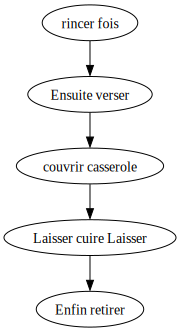

In [75]:
image(texte)

## LIMITATIONS

Since the NLP part is based solely on syntactic analysis, the ability to extract actions is limited. To be properly understood, the text must respect certain specificities:
- each action must be described in a single sentence
- The succession of sentences marks the chronology of actions.

Apart from this, syntactic analysis does not take into account conditional structures and complex dependencies between actions.